# 05 — Gymnasium Basics  
*Explore the foundation of Reinforcement Learning environments and agent–environment interaction.*

**What you'll learn**
- The **Gymnasium API**: `obs, info = env.reset()` → `obs, reward, terminated, truncated, info = env.step(action)`  
- Handling episode endings: `done = terminated or truncated`  
- Implementing a simple **random agent** baseline and visualizing episode returns  
- A minimal **tabular value estimation** example to link dynamics with learning  

> This notebook bridges theory and practice — you’ll interact with environments, collect experience, and prepare for training real RL agents.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

try:
    import gymnasium as gym
except Exception as e:
    print("Gymnasium not found. Install with: pip install gymnasium gymnasium[classic-control]")
    raise

## 1. Environment Anatomy  

In reinforcement learning, an **environment** defines the world in which an agent operates. At each time step $ t $, the agent observes a state $ s_t $, takes an action $ a_t $, and receives a reward $ r_t $ while the environment transitions to a new state $ s_{t+1} $:  

$$
(s_t, a_t, r_t, s_{t+1}) \sim \mathcal{E}
$$

The standard Gymnasium interface provides two key methods:
- `env.reset()` → initializes the environment and returns the starting observation.  
- `env.step(action)` → applies the chosen action and returns `(next_obs, reward, terminated, truncated, info)`.

An episode ends when `terminated` (goal reached/failure) or `truncated` (time limit) is `True`. The agent’s goal is to **maximize the expected return**:

$$
J(\pi) = \mathbb{E}_\pi \left[\sum_{t=0}^{T} \gamma^t r_t \right]
$$

**In RL practice:**  
- The environment models the dynamics $ P(s_{t+1} \mid s_t, a_t) $.  
- The agent learns a **policy** $ \pi(a_t \mid s_t) $ that maps observations to actions.  
- Tools like Gymnasium provide standard benchmarks (CartPole, MountainCar, etc.) to evaluate and visualize how well the agent learns to act through interaction.

In [5]:
import gymnasium as gym
import numpy as np

# Create the environment and reset it
env = gym.make("CartPole-v1")
obs, info = env.reset(seed=0)

# Show basic environment details
print("Environment details:")
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")
print(f"Max episode steps: {env.spec.max_episode_steps}")

print(f"\nInitial observation shape: {np.array(obs).shape}")
print(f"Observation sample: {obs}")
print(f"Info dictionary keys: {list(info.keys())}")

Environment details:
Action space: Discrete(2)
Observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Max episode steps: 500

Initial observation shape: (4,)
Observation sample: [ 0.01369617 -0.02302133 -0.04590265 -0.04834723]
Info dictionary keys: []


## 2. Random Policy Baseline  

Before training a smart agent, it’s important to establish a **baseline** — how well does an untrained, random policy perform?  

A **policy** $ \pi(a|s) $ defines how the agent selects actions given the current state. A random policy simply samples actions uniformly from the action space:  

$$
a_t \sim \text{Uniform}(\mathcal{A})
$$

We can then run several episodes to measure the **return** (total reward per episode):  

$$
G = \sum_{t=0}^{T} r_t
$$

This provides a useful benchmark for later comparison — a trained agent should outperform the random baseline by achieving higher average returns.  

In reinforcement learning, such baselines are critical for debugging:
- They verify the **environment setup** and reward signals.  
- They help visualize the **stochastic dynamics** of the task.  
- They serve as a **lower bound** on performance before learning begins.

Random policy — mean return: 23.52
Min: 10.00, Max: 66.00


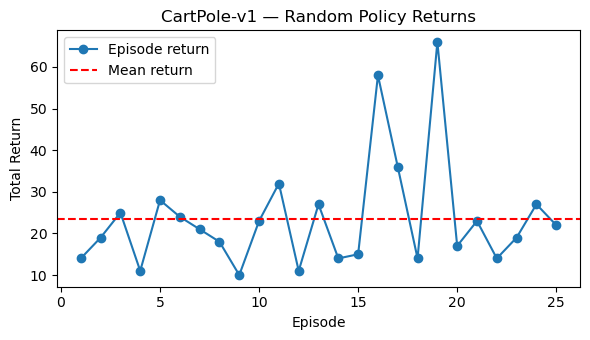

In [ ]:
def run_random_episode(env, render=False, max_steps=1000, seed=None):
    """Run one episode with a random policy and return total reward."""
    obs, info = env.reset(seed=seed)
    total_reward = 0.0

    for _ in range(max_steps):
        action = env.action_space.sample() # random action
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward

        if render:
            env.render()

        if terminated or truncated:
            break
    return total_reward

# Run multiple episodes
num_episodes = 25
returns = [run_random_episode(env, seed=i) for i in range(num_episodes)]

print(f"Random policy — mean return: {np.mean(returns):.2f}")
print(f"Min: {np.min(returns):.2f}, Max: {np.max(returns):.2f}")

# Plot episode returns
plt.figure(figsize=(6, 3.5))
plt.plot(range(1, num_episodes + 1), returns, marker="o", label="Episode return")
plt.axhline(np.mean(returns), color="red", linestyle="--", label="Mean return")
plt.title("CartPole-v1 — Random Policy Returns")
plt.xlabel("Episode")
plt.ylabel("Total Return")
plt.legend()
plt.tight_layout()
plt.show()

## 3. Simple Tabular Value Illustration (Toy)

In reinforcement learning, we often estimate the **value** of taking an action in a given state. For discrete (tabular) environments, this is represented by a **Q-table**:

$$
Q(s, a) \approx \mathbb{E}[R_t + \gamma \max_{a'} Q(s', a')]
$$

where:
- $ s $ is the current state,  
- $ a $ is an action,  
- $ R_t $ is the reward received,  
- $ s' $ is the next state, and  
- $ \gamma \in [0,1) $ is the discount factor controlling future reward importance.  

In **continuous** environments (like `CartPole`), we can’t store all states explicitly. So here, we **discretize** the observation space into coarse bins to approximate a tabular setting. We’ll then use a **bandit-like update** to tweak action preferences based on received rewards:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \big( r - Q(s, a) \big)
$$

This toy example is **not** a full RL algorithm — it only demonstrates how an agent can incrementally adjust its expectations based on experience.

**RL Connection:**
- This forms the conceptual bridge between **bandits → tabular Q-learning → deep RL**.
- Reinforcement learning generalizes this idea by using **bootstrapping**, **discounted returns**, and **function approximation**.

Random-ish softmax toy — mean return over 150 eps: 19.61
Last-10 mean: 10.60, max: 194.00


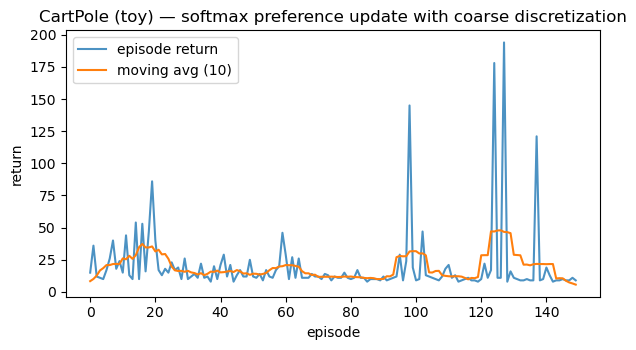

In [ ]:
from collections import defaultdict, deque

n_actions = env.action_space.n

# Coarse discretization bins for 4-D observation
# [cart position, cart velocity, pole angle, pole angular velocity]
bins = [
    np.linspace(-4.8, 4.8, 7), # 6 intervals
    np.linspace(-3.0, 3.0, 7),
    np.linspace(-0.418, 0.418, 7),
    np.linspace(-3.5, 3.5, 7),
]

def discretize(obs):
    """Map continuous obs -> tuple of bin indices (tabular key)."""
    idxs = []
    for o, b in zip(obs, bins):
        # clip before binning to avoid out-of-range indices
        o = float(np.clip(o, b.min(), b.max()))
        idxs.append(int(np.digitize(o, b) - 1)) # indices in [0, len(b)-1]
    return tuple(idxs)

# Softmax policy over tabular preferences
prefs = defaultdict(lambda: np.zeros(n_actions, dtype=np.float32))

def softmax(logits, tau=1.0):
    z = (logits - np.max(logits)) / max(tau, 1e-6)
    ez = np.exp(z, dtype=np.float64)
    return (ez / ez.sum()).astype(np.float32)

def run_episode_softmax(env, alpha=0.02, tau=0.8, max_steps=500, baseline=None):
    """One episode of softmax preference learning with immediate-reward update (bandit-like)."""
    obs, _ = env.reset()
    total = 0.0
    for _ in range(max_steps):
        s = discretize(obs)
        pi = softmax(prefs[s], tau=tau)
        a = np.random.choice(n_actions, p=pi)
        obs2, r, terminated, truncated, _ = env.step(a)
        total += r

        # Variance-reduced immediate reward (optional baseline)
        adv = r - (baseline if baseline is not None else 0.0)

        # REINFORCE-style grad for softmax prefs at state s
        grad = -pi
        grad[a] += 1.0

        # Update preferences
        prefs[s] += alpha * adv * grad

        # Small clip to keep prefs numerically tame
        prefs[s] = np.clip(prefs[s], -20.0, 20.0)

        obs = obs2
        if terminated or truncated:
            break
    return total

# Train for multiple episodes
episodes = 150
returns = []
ma = deque(maxlen=10)

for ep in range(episodes):
    # Use moving-average reward as a simple baseline
    baseline = np.mean(ma) if len(ma) > 0 else None
    ret = run_episode_softmax(env, alpha=0.02, tau=0.8, max_steps=500, baseline=baseline)
    returns.append(ret)
    ma.append(ret)

print(f"Random-ish softmax toy — mean return over {episodes} eps: {np.mean(returns):.2f}")
print(f"Last-10 mean: {np.mean(returns[-10:]):.2f}, max: {np.max(returns):.2f}")

# Plot learning curve
plt.figure(figsize=(6.2, 3.6))
plt.plot(returns, color="tab:blue", alpha=0.8, label="episode return")
# 10-ep moving average
if len(returns) >= 10:
    ma_curve = np.convolve(returns, np.ones(10)/10, mode="same")
    plt.plot(ma_curve, color="tab:orange", label="moving avg (10)")
plt.title("CartPole (toy) — softmax preference update with coarse discretization")
plt.xlabel("episode"); plt.ylabel("return"); plt.legend()
plt.tight_layout(); plt.show()

env.close()

## Key Takeaways

- **Unified Env API** — Gymnasium standardizes `reset()`/`step()` so agents interact consistently across environments.  
- **Random Baseline** — Establishes a starting benchmark and reveals environment dynamics early.  
- **From Tabular to Deep RL** — Simple discrete policies expose reward patterns before scaling to neural agents (DQN, PPO, etc.).  

**Next:** `06_basic_machine_learning.ipynb` → foundational ML concepts—regression, classification, and evaluation metrics for building RL critics and reward models.